<a href="https://colab.research.google.com/github/Hou-jing/paper_record_public/blob/main/PRGC_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/kj5f1vcomr21xyv/NYT11.zip?dl=0  -O NYT11.zip 
!unzip -q NYT11.zip

--2022-03-19 15:03:48--  https://www.dropbox.com/s/kj5f1vcomr21xyv/NYT11.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kj5f1vcomr21xyv/NYT11.zip [following]
--2022-03-19 15:03:49--  https://www.dropbox.com/s/raw/kj5f1vcomr21xyv/NYT11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f408df8b200def925b7fad63a.dl.dropboxusercontent.com/cd/0/inline/BhzGRYrXavN89I_QTk8TysCrOE90kBHxSJl6tt4mDHl79uqUgg5dBGWVwImGPmqRvjElcCnOpHDlh_aIrtrCmjSNJY2PkAfzynh_AgXrE957_WAYA5KutfOcRFENMLW3Qm8QhRMCOotFq2YBjCjMt9RMCjWuB-97BBt8yXmvXk3vtQ/file# [following]
--2022-03-19 15:03:49--  https://uc7f408df8b200def925b7fad63a.dl.dropboxusercontent.com/cd/0/inline/BhzGRYrXavN89I_QTk8TysCrOE90kBHxSJl6tt4mDHl79uqUgg5dBGWVwImGPmqRvjElcCnO

In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 46.6 MB/s 
     |████████████████████████████████| 596 kB 32.9 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!wget https://www.dropbox.com/s/pm4hrky2hxvv2po/cased_L-12_H-768_A-12%20%281%29.zip?dl=0  -O pretrained_bert_models.zip
!unzip -q pretrained_bert_models.zip

--2022-03-19 15:04:08--  https://www.dropbox.com/s/pm4hrky2hxvv2po/cased_L-12_H-768_A-12%20%281%29.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pm4hrky2hxvv2po/cased_L-12_H-768_A-12%20%281%29.zip [following]
--2022-03-19 15:04:08--  https://www.dropbox.com/s/raw/pm4hrky2hxvv2po/cased_L-12_H-768_A-12%20%281%29.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc13973f5a618d717d7222e0fe6.dl.dropboxusercontent.com/cd/0/inline/BhwFRuqBw0lIYN3CxhmCZ2vHV0OurvKPaRrYZTtoMzw426F6F9LOozGDvW-gpfirfBKEOtecwmAk3fwV68OloeNiDC1XDrNuvf18kzW9ROa9o5TLSYKsCNw6BGg0xKiBMdeMrSWD53p7MNTrFFTSZW_gdknHy-fR4LnnyZ5RWb5ipg/file# [following]
--2022-03-19 15:04:08--  https://ucc13973f5a618d717d7222e0fe6.dl.dropboxusercontent.com/cd/0/i

# utils

In [ ]:
data_dir = 'data/NYT'

In [ ]:
# /usr/bin/env python
# coding=utf-8
"""utils"""
import logging
import os
import shutil
import json
from pathlib import Path

import torch

Label2IdxSub = {"B-H": 1, "I-H": 2, "O": 0}
Label2IdxObj = {"B-T": 1, "I-T": 2, "O": 0}


class Params:
    """参数定义
    """

    def __init__(self, ex_index=1, corpus_type='NYT'):
        # self.root_path = Path(os.path.abspath(os.path.dirname(__file__)))
        self.data_dir = f'data/{corpus_type}'
        self.ex_dir = f'experiments/ex{ex_index}'
        self.model_dir =f'model/ex{ex_index}'
        self.bert_model_dir = 'cased_L-12_H-768_A-12'

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_gpu = torch.cuda.device_count()
        self.max_seq_length = 100
        self.data_cache = False
        self.train_batch_size = 1 if 'WebNLG' in corpus_type else 1
        self.val_batch_size = 1
        self.test_batch_size = 1

        # self.train_batch_size = 6 if 'WebNLG' in corpus_type else 64
        # self.val_batch_size = 24
        # self.test_batch_size = 64
        # PRST parameters
        self.seq_tag_size = len(Label2IdxSub)
        # load label2id
        self.rel2idx = json.load(open(self.data_dir+'/rel2id.json', 'r', encoding='utf-8'))[-1]
        self.rel_num = len(self.rel2idx)

        # early stop strategy
        self.min_epoch_num = 20
        self.patience = 0.00001
        self.patience_num = 20

        # learning rate
        self.fin_tuning_lr = 1e-4
        self.downs_en_lr = 1e-3
        self.clip_grad = 2.
        self.drop_prob = 0.3  # dropout
        self.weight_decay_rate = 0.01
        self.warmup_prop = 0.1
        self.gradient_accumulation_steps = 2

    def load(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        """保存配置到json文件
        """
        params = {}
        with open(json_path, 'w') as f:
            for k, v in self.__dict__.items():
                if isinstance(v, (str, int, float, bool)):
                    params[k] = v
            json.dump(params, f, indent=4)


class RunningAverage:
    """A simple class that maintains the running average of a quantity

    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)


def set_logger(save=False, log_path=None):
    """Set the logger to log info in terminal and file `log_path`.

    In general, it is useful to have a logger so that every output to the terminal is saved
    in a permanent file. Here we save it to `model_dir/train.log`.

    Example:
    ```
    logging.info("Starting training...")
    ```

    Args:
        log_path: (string) where to log
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if save and not os.path.exists(os.path.dirname(log_path)):
        os.makedirs(os.path.dirname(log_path))

    if not logger.handlers:
        if save:
            # Logging to a file
            file_handler = logging.FileHandler(log_path)
            file_handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s: %(message)s'))
            logger.addHandler(file_handler)

        # Logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(stream_handler)


def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'

    Args:
        state: (dict) contains the entire model, may contain other keys such as epoch, optimizer
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.makedirs(checkpoint)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, optimizer=True):
    """Loads entire model from file_path. If optimizer is True, loads
    optimizer assuming it is present in checkpoint.

    Args:
        checkpoint: (string) filename which needs to be loaded
        optimizer: (bool) resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise ValueError("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))

    if optimizer:
        return checkpoint['model'], checkpoint['optim']
    return checkpoint['model']


# dataloader_utils

In [ ]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
import json
import random
from multiprocessing import Pool
import functools
import numpy as np
from collections import defaultdict
from itertools import chain



class InputExample(object):
    """a single set of samples of data
    """

    def __init__(self, text, en_pair_list, re_list, rel2ens):
        self.text = text
        self.en_pair_list = en_pair_list
        self.re_list = re_list
        self.rel2ens = rel2ens


class InputFeatures(object):
    """
    Desc:
        a single set of features of data
    """

    def __init__(self,
                 input_tokens,
                 input_ids,
                 attention_mask,
                 seq_tag=None,
                 corres_tag=None,#gloal matrix
                 relation=None,
                 triples=None,
                 rel_tag=None
                 ):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.seq_tag = seq_tag
        self.corres_tag = corres_tag
        self.relation = relation
        self.triples = triples
        self.rel_tag = rel_tag


def read_examples(data_dir, data_sign, rel2idx):
    """load data to InputExamples
    """
    examples = []

    # read src data
    with open(data_dir + f'/{data_sign}_triples.json', "r", encoding='utf-8') as f:
        data = json.load(f)
        for sample in data:
            text = sample['text']
            rel2ens = defaultdict(list)
            en_pair_list = []
            re_list = []

            for triple in sample['triple_list']:
                en_pair_list.append([triple[0], triple[-1]])
                re_list.append(rel2idx[triple[1]])
                rel2ens[rel2idx[triple[1]]].append((triple[0], triple[-1]))
            example = InputExample(text=text, en_pair_list=en_pair_list, re_list=re_list, rel2ens=rel2ens)
            examples.append(example)
    print("InputExamples:", len(examples))
    return examples


def find_head_idx(source, target):
    target_len = len(target)
    for i in range(len(source)):
        if source[i: i + target_len] == target:
            return i
    return -1

#返回的是sub_head, obj_head, sub, obj
def _get_so_head(en_pair, tokenizer, text_tokens):
    sub = tokenizer.tokenize(en_pair[0])
    obj = tokenizer.tokenize(en_pair[1])
    sub_head = find_head_idx(source=text_tokens, target=sub)
    if sub == obj:
        obj_head = find_head_idx(source=text_tokens[sub_head + len(sub):], target=obj)
        if obj_head != -1:
            obj_head += sub_head + len(sub)
        else:
            obj_head = sub_head
    else:
        obj_head = find_head_idx(source=text_tokens, target=obj)
    return sub_head, obj_head, sub, obj


def convert(example, max_text_len, tokenizer, rel2idx, data_sign, ex_params):
    """convert function
    """
    text_tokens = tokenizer.tokenize(example.text)
    # cut off
    if len(text_tokens) > max_text_len:
        text_tokens = text_tokens[:max_text_len]

    # token to id
    input_ids = tokenizer.convert_tokens_to_ids(text_tokens)
    attention_mask = [1] * len(input_ids)
    # zero-padding up to the sequence length
    if len(input_ids) < max_text_len:
        pad_len = max_text_len - len(input_ids)
        # token_pad_id=0
        input_ids += [0] * pad_len
        attention_mask += [0] * pad_len

    # train data
    if data_sign == 'train':
        # construct tags of correspondence and relation
        corres_tag = np.zeros((max_text_len, max_text_len))
        rel_tag = len(rel2idx) * [0]
        for en_pair, rel in zip(example.en_pair_list, example.re_list):
            # get sub and obj head
            sub_head, obj_head, _, _ = _get_so_head(en_pair, tokenizer, text_tokens)
            # construct relation tag
            rel_tag[rel] = 1
            if sub_head != -1 and obj_head != -1:
                corres_tag[sub_head][obj_head] = 1

        sub_feats = []
        # positive samples
        #给头尾实体做tag标注（tags_sub，tags_obj）
        for rel, en_ll in example.rel2ens.items():
            # init
            tags_sub = max_text_len * [Label2IdxSub['O']]
            tags_obj = max_text_len * [Label2IdxSub['O']]
            for en in en_ll:
                # get sub and obj head
                sub_head, obj_head, sub, obj = _get_so_head(en, tokenizer, text_tokens)
                if sub_head != -1 and obj_head != -1:
                    if sub_head + len(sub) <= max_text_len:
                        tags_sub[sub_head] = Label2IdxSub['B-H']
                        tags_sub[sub_head + 1:sub_head + len(sub)] = (len(sub) - 1) * [Label2IdxSub['I-H']]
                    if obj_head + len(obj) <= max_text_len:
                        tags_obj[obj_head] = Label2IdxObj['B-T']
                        tags_obj[obj_head + 1:obj_head + len(obj)] = (len(obj) - 1) * [Label2IdxObj['I-T']]
            seq_tag = [tags_sub, tags_obj]

            # sanity check
            assert len(input_ids) == len(tags_sub) == len(tags_obj) == len(
                attention_mask) == max_text_len, f'length is not equal!!'
            sub_feats.append(InputFeatures(
                input_tokens=text_tokens,
                input_ids=input_ids,
                attention_mask=attention_mask,
                corres_tag=corres_tag,
                seq_tag=seq_tag,
                relation=rel,
                rel_tag=rel_tag
            ))
        # relation judgement ablation
        if not ex_params['ensure_rel']:
            # negative samples
            neg_rels = set(rel2idx.values()).difference(set(example.re_list))
            neg_rels = random.sample(neg_rels, k=ex_params['num_negs'])
            for neg_rel in neg_rels:
                # init
                seq_tag = max_text_len * [Label2IdxSub['O']]
                # sanity check
                assert len(input_ids) == len(seq_tag) == len(attention_mask) == max_text_len, f'length is not equal!!'
                seq_tag = [seq_tag, seq_tag]
                sub_feats.append(InputFeatures(
                    input_tokens=text_tokens,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    corres_tag=corres_tag,
                    seq_tag=seq_tag,
                    relation=neg_rel,
                    rel_tag=rel_tag
                ))
    # val and test data
    else:
        triples = []
        for rel, en in zip(example.re_list, example.en_pair_list):
            # get sub and obj head
            sub_head, obj_head, sub, obj = _get_so_head(en, tokenizer, text_tokens)
            if sub_head != -1 and obj_head != -1:
                h_chunk = ('H', sub_head, sub_head + len(sub))
                t_chunk = ('T', obj_head, obj_head + len(obj))
                triples.append((h_chunk, t_chunk, rel))
        sub_feats = [
            InputFeatures(
                input_tokens=text_tokens,
                input_ids=input_ids,
                attention_mask=attention_mask,
                triples=triples
            )
        ]

    # get sub-feats
    return sub_feats


def convert_examples_to_features(params, examples, tokenizer, rel2idx, data_sign, ex_params):
    """convert examples to features.
    :param examples (List[InputExamples])
    """
    max_text_len = params.max_seq_length
    # multi-process
    with Pool(10) as p:
        convert_func = functools.partial(convert, max_text_len=max_text_len, tokenizer=tokenizer, rel2idx=rel2idx,
                                         data_sign=data_sign, ex_params=ex_params)
        features = p.map(func=convert_func, iterable=examples)

    return list(chain(*features))


# dataloader

In [ ]:
# /usr/bin/env python
# coding=utf-8
"""Dataloader"""

import os
import json

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import BertTokenizer

# from dataloader_utils import read_examples, convert_examples_to_features


class FeatureDataset(Dataset):
    """Pytorch Dataset for InputFeatures
    """

    def __init__(self, features):
        self.features = features

    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index]


class CustomDataLoader(object):
    def __init__(self, params):
        self.params = params

        self.train_batch_size = params.train_batch_size
        self.val_batch_size = params.val_batch_size
        self.test_batch_size = params.test_batch_size

        self.data_dir = params.data_dir
        self.max_seq_length = params.max_seq_length
        # self.tokenizer = BertTokenizer(vocab_file=os.path.join(params.bert_model_dir, 'vocab.txt'),
        #                                do_lower_case=
        self.tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
        self.data_cache = params.data_cache

    @staticmethod
    def collate_fn_train(features):
        """将InputFeatures转换为Tensor
        Args:
            features (List[InputFeatures])
        Returns:
            tensors (List[Tensors])
        """
        input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        seq_tags = torch.tensor([f.seq_tag for f in features], dtype=torch.long)
        poten_relations = torch.tensor([f.relation for f in features], dtype=torch.long)
        corres_tags = torch.tensor([f.corres_tag for f in features], dtype=torch.long)
        rel_tags = torch.tensor([f.rel_tag for f in features], dtype=torch.long)
        tensors = [input_ids, attention_mask, seq_tags, poten_relations, corres_tags, rel_tags]
        return tensors

    @staticmethod
    def collate_fn_test(features):
        """将InputFeatures转换为Tensor
        Args:
            features (List[InputFeatures])
        Returns:
            tensors (List[Tensors])
        """
        input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        triples = [f.triples for f in features]
        input_tokens = [f.input_tokens for f in features]
        tensors = [input_ids, attention_mask, triples, input_tokens]
        return tensors

    def get_features(self, data_sign, ex_params):
        """convert InputExamples to InputFeatures
        :param data_sign: 'train', 'val' or 'test'
        """
        print("=*=" * 10)
        print("Loading {} data...".format(data_sign))
        # get features
        cache_path = os.path.join(self.data_dir, "{}.cache.{}".format(data_sign, str(self.max_seq_length)))
        if os.path.exists(cache_path) and self.data_cache:
            features = torch.load(cache_path)
        else:
            # get relation to idx
            with open(self.data_dir +'/rel2id.json', 'r', encoding='utf-8') as f_re:
                rel2idx = json.load(f_re)[-1]
            # get examples
            if data_sign in ("train", "val", "test", "pseudo", 'EPO', 'SEO', 'SOO', 'Normal', '1', '2', '3', '4', '5'):
                examples = read_examples(self.data_dir, data_sign=data_sign, rel2idx=rel2idx)
            else:
                raise ValueError("please notice that the data can only be train/val/test!!")
            features = convert_examples_to_features(self.params, examples, self.tokenizer, rel2idx, data_sign,
                                                    ex_params)
            # save data
            if self.data_cache:
                torch.save(features, cache_path)
        return features

    def get_dataloader(self, data_sign="train", ex_params=None):
        """construct dataloader
        :param data_sign: 'train', 'val' or 'test'
        """
        # InputExamples to InputFeatures
        features = self.get_features(data_sign=data_sign, ex_params=ex_params)
        dataset = FeatureDataset(features)
        print(f"{len(features)} {data_sign} data loaded!")
        print("=*=" * 10)
        # construct dataloader
        # RandomSampler(dataset) or SequentialSampler(dataset)
        if data_sign == "train":
            datasampler = RandomSampler(dataset)
            dataloader = DataLoader(dataset, sampler=datasampler, batch_size=self.train_batch_size,
                                    collate_fn=self.collate_fn_train)
        elif data_sign == "val":
            datasampler = SequentialSampler(dataset)
            dataloader = DataLoader(dataset, sampler=datasampler, batch_size=self.val_batch_size,
                                    collate_fn=self.collate_fn_test)
        elif data_sign in ("test", "pseudo", 'EPO', 'SEO', 'SOO', 'Normal', '1', '2', '3', '4', '5'):
            datasampler = SequentialSampler(dataset)
            dataloader = DataLoader(dataset, sampler=datasampler, batch_size=self.test_batch_size,
                                    collate_fn=self.collate_fn_test)
        else:
            raise ValueError("please notice that the data can only be train/val/test !!")
        return dataloader


if __name__ == '__main__':
    # from utils import Params

    params = Params(corpus_type='NYT')
    ex_params = {
        'ensure_relpre': True
    }
    dataloader = CustomDataLoader(params)
    feats = dataloader.get_features(ex_params=ex_params, data_sign='test')
    print(feats[7].input_tokens)


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

=*==*==*==*==*==*==*==*==*==*=
Loading test data...
InputExamples: 369
['In', 'essence', 'this', 'can', 'start', 'to', 're', '##w', '##rite', 'the', 'history', 'of', 'photography', ',', "'", "'", 'said', 'Grant', 'Rome', '##r', ',', 'director', 'of', 'the', 'advanced', 'residency', 'program', 'in', 'photograph', 'conservation', 'at', 'the', 'George', 'Eastman', 'House', 'in', 'Rochester', '.', "'", "'"]


# metrics

In [ ]:
# /usr/bin/env python
# coding=utf-8


def get_chunk_type(tok, idx_to_tag):
    """
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}
    Returns:
        tuple: "B", "PER"
    """
    tag_name = idx_to_tag[tok]
    content = tag_name.split('-')
    tag_class = content[0]
    if len(content) == 1:
        return tag_class
    ht = content[-1]
    return tag_class, ht


def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position
    Args:
        seq: np.array[4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4
    Returns:
        list of (chunk_type, chunk_start, chunk_end)
    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]
    """
    default1 = tags['O']
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    chunks = []
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default1 and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default1:
            res = get_chunk_type(tok, idx_to_tag)
            if len(res) == 1:
                continue
            tok_chunk_class, ht = get_chunk_type(tok, idx_to_tag)
            tok_chunk_type = ht
            if chunk_type is None:
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass
    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks


def tag_mapping_nearest(predict_tags, pre_rels=None, label2idx_sub=None, label2idx_obj=None):
    """
    implement of the heuristic nearest principle
    Args:
        predict_tags: np.array, (xi, 2, max_sen_len)
        pre_rels: (xi,)
    """
    rel_num = predict_tags.shape[0]
    pre_triples = []
    for idx in range(rel_num):
        heads, tails = [], []
        pred_chunks_sub = get_chunks(predict_tags[idx][0], label2idx_sub)
        pred_chunks_obj = get_chunks(predict_tags[idx][1], label2idx_obj)
        pred_chunks = pred_chunks_sub + pred_chunks_obj
        for ch in pred_chunks:
            if ch[0] == 'H':
                heads.append(ch)
            elif ch[0] == 'T':
                tails.append(ch)
        # the heuristic nearest principle
        if len(heads) != 0 and len(tails) != 0:
            if len(heads) < len(tails):
                heads += [heads[-1]] * (len(tails) - len(heads))
            if len(heads) > len(tails):
                tails += [tails[-1]] * (len(heads) - len(tails))

        for h_t in zip(heads, tails):
            if pre_rels is not None:
                triple = list(h_t) + [pre_rels[idx]]
            else:
                triple = list(h_t) + [idx]
            pre_triples.append(tuple(triple))
    return pre_triples


def tag_mapping_corres(predict_tags, pre_corres, pre_rels=None, label2idx_sub=None, label2idx_obj=None):
    """
    Args:
        predict_tags: np.array, (xi, 2, max_sen_len)
        pre_corres: (seq_len, seq_len)
        pre_rels: (xi,)
    """
    rel_num = predict_tags.shape[0]
    pre_triples = []
    for idx in range(rel_num):
        heads, tails = [], []
        pred_chunks_sub = get_chunks(predict_tags[idx][0], label2idx_sub)
        pred_chunks_obj = get_chunks(predict_tags[idx][1], label2idx_obj)
        pred_chunks = pred_chunks_sub + pred_chunks_obj
        for ch in pred_chunks:
            if ch[0] == 'H':
                heads.append(ch)
            elif ch[0] == 'T':
                tails.append(ch)
        retain_hts = [(h, t) for h in heads for t in tails if pre_corres[h[1]][t[1]] == 1]
        for h_t in retain_hts:
            if pre_rels is not None:
                triple = list(h_t) + [pre_rels[idx]]
            else:
                triple = list(h_t) + [idx]
            pre_triples.append(tuple(triple))
    return pre_triples


# optimizer

In [ ]:
# coding=utf-8
# This file is derived from the code at
# https://github.com/huggingface/transformers/blob/master/transformers/optimization.py
#
# Original copyright notice:
#
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch optimization for BERT model."""

import math
import torch
from torch.optim.optimizer import Optimizer
from torch.nn.utils import clip_grad_norm_
import logging
import abc
import sys

logger = logging.getLogger(__name__)

if sys.version_info >= (3, 4):
    ABC = abc.ABC
else:
    ABC = abc.ABCMeta('ABC', (), {})


class _LRSchedule(ABC):
    """ Parent of all LRSchedules here. """
    warn_t_total = False  # is set to True for schedules where progressing beyond t_total steps doesn't make sense

    def __init__(self, warmup=0.002, t_total=-1, **kw):
        """
        :param warmup:  what fraction of t_total steps will be used for linear warmup
        :param t_total: how many training steps (updates) are planned
        :param kw:
        """
        super(_LRSchedule, self).__init__(**kw)
        if t_total < 0:
            logger.warning("t_total value of {} results in schedule not being applied".format(t_total))
        if not 0.0 <= warmup < 1.0 and not warmup == -1:
            raise ValueError("Invalid warmup: {} - should be in [0.0, 1.0[ or -1".format(warmup))
        warmup = max(warmup, 0.)
        self.warmup, self.t_total = float(warmup), float(t_total)
        self.warned_for_t_total_at_progress = -1

    def get_lr(self, step, nowarn=False):
        """
        :param step:    which of t_total steps we're on
        :param nowarn:  set to True to suppress warning regarding training beyond specified 't_total' steps
        :return:        learning rate multiplier for current update
        """
        if self.t_total < 0:
            return 1.
        progress = float(step) / self.t_total
        ret = self.get_lr_(progress)
        # warning for exceeding t_total (only active with warmup_linear
        if not nowarn and self.warn_t_total and progress > 1. and progress > self.warned_for_t_total_at_progress:
            logger.warning(
                "Training beyond specified 't_total'. Learning rate multiplier set to {}. Please set 't_total' of {} correctly."
                    .format(ret, self.__class__.__name__))
            self.warned_for_t_total_at_progress = progress
        # end warning
        return ret

    @abc.abstractmethod
    def get_lr_(self, progress):
        """
        :param progress:    value between 0 and 1 (unless going beyond t_total steps) specifying training progress
        :return:            learning rate multiplier for current update
        """
        return 1.


class ConstantLR(_LRSchedule):
    def get_lr_(self, progress):
        return 1.


class WarmupCosineSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Decreases learning rate from 1. to 0. over remaining `1 - warmup` steps following a cosine curve.
    If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    warn_t_total = True

    def __init__(self, warmup=0.002, t_total=-1, cycles=.5, **kw):
        """
        :param warmup:      see LRSchedule
        :param t_total:     see LRSchedule
        :param cycles:      number of cycles. Default: 0.5, corresponding to cosine decay from 1. at progress==warmup and 0 at progress==1.
        :param kw:
        """
        super(WarmupCosineSchedule, self).__init__(warmup=warmup, t_total=t_total, **kw)
        self.cycles = cycles

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)  # progress after warmup
            return 0.5 * (1. + math.cos(math.pi * self.cycles * 2 * progress))


class WarmupCosineWithHardRestartsSchedule(WarmupCosineSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    If `cycles` (default=1.) is different from default, learning rate follows `cycles` times a cosine decaying
    learning rate (with hard restarts).
    """

    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        super(WarmupCosineWithHardRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)
        assert (cycles >= 1.)

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)  # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * ((self.cycles * progress) % 1)))
            return ret


class WarmupCosineWithWarmupRestartsSchedule(WarmupCosineWithHardRestartsSchedule):
    """
    All training progress is divided in `cycles` (default=1.) parts of equal length.
    Every part follows a schedule with the first `warmup` fraction of the training steps linearly increasing from 0. to 1.,
    followed by a learning rate decreasing from 1. to 0. following a cosine curve.
    """

    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        assert (warmup * cycles < 1.)
        warmup = warmup * cycles if warmup >= 0 else warmup
        super(WarmupCosineWithWarmupRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles,
                                                                     **kw)

    def get_lr_(self, progress):
        progress = progress * self.cycles % 1.
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)  # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * progress))
            return ret


class WarmupConstantSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Keeps learning rate equal to 1. after warmup.
    """

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return 1.


class WarmupLinearSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Linearly decreases learning rate from 1. to 0. over remaining `1 - warmup` steps.
    """
    warn_t_total = True

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return max((progress - 1.) / (self.warmup - 1.), 0.)


SCHEDULES = {
    None: ConstantLR,
    "none": ConstantLR,
    "warmup_cosine": WarmupCosineSchedule,
    "warmup_constant": WarmupConstantSchedule,
    "warmup_linear": WarmupLinearSchedule
}


class BertAdam(Optimizer):
    """Implements BERT version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1 means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate of 1. (no warmup regardless of warmup setting). Default: -1
        schedule: schedule to use for the warmup (see above).
            Can be `'warmup_linear'`, `'warmup_constant'`, `'warmup_cosine'`, `'none'`, `None` or a `_LRSchedule` object (see below).
            If `None` or `'none'`, learning rate is always kept constant.
            Default : `'warmup_linear'`
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """

    def __init__(self, params, lr=1e-4, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-6, weight_decay=0.01, max_grad_norm=1.0, **kwargs):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not isinstance(schedule, _LRSchedule) and schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not e >= 0.0:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(e))
        # initialize schedule object
        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning(
                    "warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                    "Please specify custom warmup and t_total in _LRSchedule object.")
        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm)
        super(BertAdam, self).__init__(params, defaults)

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['next_m'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['next_v'] = torch.zeros_like(p.data)

                next_m, next_v = state['next_m'], state['next_v']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                next_m.mul_(beta1).add_(alpha=1 - beta1, other=grad)
                next_v.mul_(beta2).addcmul_(value=1 - beta2, tensor1=grad, tensor2=grad)
                update = next_m / (next_v.sqrt() + group['e'])

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                if group['weight_decay'] > 0.0:
                    update += group['weight_decay'] * p.data

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])

                update_with_lr = lr_scheduled * update
                p.data.add_(-update_with_lr)

                state['step'] += 1

                # step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1
                # No bias correction
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']

        return loss


In [ ]:
! wgethttps://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json

# model

In [ ]:
# /usr/bin/env python
# coding=utf-8
"""model"""
from collections import Counter

import torch
import torch.nn as nn

from transformers import BertPreTrainedModel, BertModel, BertTokenizer


class MultiNonLinearClassifier(nn.Module):
    def __init__(self, hidden_size, tag_size, dropout_rate):
        super(MultiNonLinearClassifier, self).__init__()
        self.tag_size = tag_size
        self.linear = nn.Linear(hidden_size, int(hidden_size / 2))
        self.hidden2tag = nn.Linear(int(hidden_size / 2), self.tag_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_features):
        features_tmp = self.linear(input_features)
        features_tmp = nn.ReLU()(features_tmp)
        features_tmp = self.dropout(features_tmp)
        features_output = self.hidden2tag(features_tmp)
        return features_output


class SequenceLabelForSO(nn.Module):
    def __init__(self, hidden_size, tag_size, dropout_rate):
        super(SequenceLabelForSO, self).__init__()
        self.tag_size = tag_size
        self.linear = nn.Linear(hidden_size, int(hidden_size / 2))
        self.hidden2tag_sub = nn.Linear(int(hidden_size / 2), self.tag_size)
        self.hidden2tag_obj = nn.Linear(int(hidden_size / 2), self.tag_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_features):
        """
        Args:
            input_features: (bs, seq_len, h)
        """
        features_tmp = self.linear(input_features)
        features_tmp = nn.ReLU()(features_tmp)
        features_tmp = self.dropout(features_tmp)
        sub_output = self.hidden2tag_sub(features_tmp)
        obj_output = self.hidden2tag_obj(features_tmp)
        return sub_output, obj_output


class BertForRE(BertPreTrainedModel):
    def __init__(self, config, params):
        super().__init__(config)
        self.max_seq_len = params.max_seq_length
        self.seq_tag_size = params.seq_tag_size
        self.rel_num = params.rel_num

        # pretrain model
        # self.bert = BertModel(config)
        self.bert = BertModel.from_pretrained('bert-base-cased')
        # sequence tagging
        self.sequence_tagging_sub = MultiNonLinearClassifier(config.hidden_size * 2, self.seq_tag_size, params.drop_prob)
        self.sequence_tagging_obj = MultiNonLinearClassifier(config.hidden_size * 2, self.seq_tag_size, params.drop_prob)
        self.sequence_tagging_sum = SequenceLabelForSO(config.hidden_size, self.seq_tag_size, params.drop_prob)
        # global correspondence
        self.global_corres = MultiNonLinearClassifier(config.hidden_size * 2, 1, params.drop_prob)
        # relation judgement
        self.rel_judgement = MultiNonLinearClassifier(config.hidden_size, params.rel_num, params.drop_prob)
        self.rel_embedding = nn.Embedding(params.rel_num, config.hidden_size)

        self.init_weights()

    @staticmethod
    def masked_avgpool(sent, mask):
        mask_ = mask.masked_fill(mask == 0, -1e9).float()
        score = torch.softmax(mask_, -1)#权重的平均
        return torch.matmul(score.unsqueeze(1), sent).squeeze(1)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            seq_tags=None,
            potential_rels=None,
            corres_tags=None,
            rel_tags=None,
            ex_params=None
    ):
        """
        Args:
            input_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)
            rel_tags: (bs, rel_num)
            potential_rels: (bs,), only in train stage.
            seq_tags: (bs, 2, seq_len)
            corres_tags: (bs, seq_len, seq_len)
            ex_params: experiment parameters
        """
        # get params for experiments
        corres_threshold, rel_threshold = ex_params.get('corres_threshold', 0.5), ex_params.get('rel_threshold', 0.1)
        # ablation study
        ensure_corres, ensure_rel = ex_params['ensure_corres'], ex_params['ensure_rel']
        # pre-train model
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )  # sequence_output, pooled_output, (hidden_states), (attentions)
        sequence_output = outputs[0]
        bs, seq_len, h = sequence_output.size()

        if ensure_rel:
            # (bs, h)
            h_k_avg = self.masked_avgpool(sequence_output, attention_mask)
            # (bs, rel_num)
            rel_pred = self.rel_judgement(h_k_avg)

        # before fuse relation representation
        if ensure_corres:
            # for every position $i$ in sequence, should concate $j$ to predict.
            sub_extend = sequence_output.unsqueeze(2).expand(-1, -1, seq_len, -1)  # (bs, s, s, h)
            obj_extend = sequence_output.unsqueeze(1).expand(-1, seq_len, -1, -1)  # (bs, s, s, h)
            # batch x seq_len x seq_len x 2*hidden
            corres_pred = torch.cat([sub_extend, obj_extend], 3)
            # (bs, seq_len, seq_len)
            corres_pred = self.global_corres(corres_pred).squeeze(-1)
            mask_tmp1 = attention_mask.unsqueeze(-1)#B*L*1
            mask_tmp2 = attention_mask.unsqueeze(1)#B*1*L
            corres_mask = mask_tmp1 * mask_tmp2#B*L*L

        # relation predict and data construction in inference stage
        xi, pred_rels = None, None
        if ensure_rel and seq_tags is None:
            # (bs, rel_num)
            #这里乜有太理解
            rel_pred_onehot = torch.where(torch.sigmoid(rel_pred) > rel_threshold,
                                          torch.ones(rel_pred.size(), device=rel_pred.device),
                                          torch.zeros(rel_pred.size(), device=rel_pred.device))

            # if potential relation is null
            for idx, sample in enumerate(rel_pred_onehot):
                if 1 not in sample:
                    # (rel_num,)
                    max_index = torch.argmax(rel_pred[idx])
                    sample[max_index] = 1
                    rel_pred_onehot[idx] = sample

            # 2*(sum(x_i),)
            bs_idxs, pred_rels = torch.nonzero(rel_pred_onehot, as_tuple=True)
            # get x_i
            xi_dict = Counter(bs_idxs.tolist())
            xi = [xi_dict[idx] for idx in range(bs)]

            pos_seq_output = []
            pos_potential_rel = []
            pos_attention_mask = []
            for bs_idx, rel_idx in zip(bs_idxs, pred_rels):
                # (seq_len, h)
                pos_seq_output.append(sequence_output[bs_idx])
                pos_attention_mask.append(attention_mask[bs_idx])
                pos_potential_rel.append(rel_idx)
            # (sum(x_i), seq_len, h)
            sequence_output = torch.stack(pos_seq_output, dim=0)
            # (sum(x_i), seq_len)
            attention_mask = torch.stack(pos_attention_mask, dim=0)
            # (sum(x_i),)
            potential_rels = torch.stack(pos_potential_rel, dim=0)
        # ablation of relation judgement
        elif not ensure_rel and seq_tags is None:
            # construct test data
            #当参数只有两个时，第一个参数表示的是复制后的列数，第二个参数表示复制后的行数。
            # 当参数有三个时，第一个参数表示的是复制后的通道数，第二个参数表示的是复制后的列数，第三个参数表示复制后的行数。
            sequence_output = sequence_output.repeat((1, self.rel_num, 1)).view(bs * self.rel_num, seq_len, h)
            attention_mask = attention_mask.repeat((1, self.rel_num)).view(bs * self.rel_num, seq_len)
            potential_rels = torch.arange(0, self.rel_num, device=input_ids.device).repeat(bs)

        # (bs/sum(x_i), h)
        rel_emb = self.rel_embedding(potential_rels)

        # relation embedding vector fusion
        rel_emb = rel_emb.unsqueeze(1).expand(-1, seq_len, h)
        if ex_params['emb_fusion'] == 'concat':
            # (bs/sum(x_i), seq_len, 2*h)
            decode_input = torch.cat([sequence_output, rel_emb], dim=-1)
            # (bs/sum(x_i), seq_len, tag_size)
            output_sub = self.sequence_tagging_sub(decode_input)
            output_obj = self.sequence_tagging_obj(decode_input)
        elif ex_params['emb_fusion'] == 'sum':
            # (bs/sum(x_i), seq_len, h)
            decode_input = sequence_output + rel_emb
            # (bs/sum(x_i), seq_len, tag_size)
            output_sub, output_obj = self.sequence_tagging_sum(decode_input)

        # train
        if seq_tags is not None:
            # calculate loss
            attention_mask = attention_mask.view(-1)
            # sequence label loss
            loss_func = nn.CrossEntropyLoss(reduction='none')
            loss_seq_sub = (loss_func(output_sub.view(-1, self.seq_tag_size),
                                      seq_tags[:, 0, :].reshape(-1)) * attention_mask).sum() / attention_mask.sum()
            loss_seq_obj = (loss_func(output_obj.view(-1, self.seq_tag_size),
                                      seq_tags[:, 1, :].reshape(-1)) * attention_mask).sum() / attention_mask.sum()
            loss_seq = (loss_seq_sub + loss_seq_obj) / 2
            # init
            loss_matrix, loss_rel = torch.tensor(0), torch.tensor(0)
            if ensure_corres:
                corres_pred = corres_pred.view(bs, -1)
                corres_mask = corres_mask.view(bs, -1)
                corres_tags = corres_tags.view(bs, -1)
                loss_func = nn.BCEWithLogitsLoss(reduction='none')
                loss_matrix = (loss_func(corres_pred,
                                         corres_tags.float()) * corres_mask).sum() / corres_mask.sum()

            if ensure_rel:
                loss_func = nn.BCEWithLogitsLoss(reduction='mean')
                loss_rel = loss_func(rel_pred, rel_tags.float())

            loss = loss_seq + loss_matrix + loss_rel
            return loss, loss_seq, loss_matrix, loss_rel
        # inference
        else:
            # (sum(x_i), seq_len)
            pred_seq_sub = torch.argmax(torch.softmax(output_sub, dim=-1), dim=-1)
            pred_seq_obj = torch.argmax(torch.softmax(output_obj, dim=-1), dim=-1)
            # (sum(x_i), 2, seq_len)
            pred_seqs = torch.cat([pred_seq_sub.unsqueeze(1), pred_seq_obj.unsqueeze(1)], dim=1)
            if ensure_corres:
                corres_pred = torch.sigmoid(corres_pred) * corres_mask
                # (bs, seq_len, seq_len)
                pred_corres_onehot = torch.where(corres_pred > corres_threshold,
                                                 torch.ones(corres_pred.size(), device=corres_pred.device),
                                                 torch.zeros(corres_pred.size(), device=corres_pred.device))
                return pred_seqs, pred_corres_onehot, xi, pred_rels
            return pred_seqs, xi, pred_rels





if __name__ == '__main__':
    from transformers import BertConfig

    import os

    params = Params()
    # Prepare model
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_config = BertConfig.from_json_file(os.path.join(params.bert_model_dir, 'bert_config.json'))
    model = BertForRE.from_pretrained(config=bert_config,
                                      # pretrained_model_name_or_path=params.bert_model_dir,
                                      pretrained_model_name_or_path='bert-base-cased',
                                      params=params)
    model.to(params.device)

    for n, _ in model.named_parameters():
        print(n)


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForRE: ['cls.predictions.transform.dense.bias', 'cls.predictions.

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

# train

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import torch
from transformers import BertConfig
import random
import logging
from tqdm import trange
import argparse
import os


In [ ]:
# load args
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=2020, help="random seed for initialization")
parser.add_argument('--ex_index', type=str, default=1)
parser.add_argument('--corpus_type', type=str, default="NYT", help="NYT, WebNLG, NYT*, WebNLG*")
parser.add_argument('--device_id', type=int, default=0, help="GPU index")
# parser.add_argument('--epoch_num', required=True, type=int, help="number of epochs")
parser.add_argument('--epoch_num', default=2, type=int, help="number of epochs")
# parser.add_argument('--multi_gpu', action='store_true', help="ensure multi-gpu training")
parser.add_argument('--restore_file', default=None, help="name of the file containing weights to reload")

parser.add_argument('--corres_threshold', type=float, default=0.5, help="threshold of global correspondence")
parser.add_argument('--rel_threshold', type=float, default=0.5, help="threshold of relation judgement")
parser.add_argument('--ensure_corres', action='store_true', help="correspondence ablation")
parser.add_argument('--ensure_rel', action='store_true', help="relation judgement ablation")
parser.add_argument('--emb_fusion', type=str, default="concat", help="way to embedding")

parser.add_argument('--num_negs', type=int, default=4,
                    help="number of negative sample when ablate relation judgement")

_StoreAction(option_strings=['--num_negs'], dest='num_negs', nargs=None, const=None, default=4, type=<class 'int'>, choices=None, help='number of negative sample when ablate relation judgement', metavar=None)

## train

In [ ]:
# /usr/bin/env python
# coding=utf-8
"""train with valid"""



# import utils
# from optimization import BertAdam
# from evaluate import evaluate
# from dataloader import CustomDataLoader
# from model import BertForRE




def train(model, data_iterator, optimizer, params, ex_params):
    """Train the model one epoch
    """
    # set model to training mode
    model.train()

    loss_avg = RunningAverage()
    loss_avg_seq = RunningAverage()
    loss_avg_mat = RunningAverage()
    loss_avg_rel = RunningAverage()

    # Use tqdm for progress bar
    # one epoch
    t = trange(len(data_iterator), ascii=True)
    for step, _ in enumerate(t):
        # fetch the next training batch
        batch = next(iter(data_iterator))
        batch = tuple(t.to(params.device) for t in batch)
        input_ids, attention_mask, seq_tags, relations, corres_tags, rel_tags = batch

        # compute model output and loss
        loss, loss_seq, loss_mat, loss_rel = model(input_ids, attention_mask=attention_mask, seq_tags=seq_tags,
                                                   potential_rels=relations, corres_tags=corres_tags, rel_tags=rel_tags,
                                                   ex_params=ex_params)

        if params.n_gpu > 1 and args.multi_gpu:
            loss = loss.mean()  # mean() to average on multi-gpu.
        if params.gradient_accumulation_steps > 1:
            loss = loss / params.gradient_accumulation_steps

        # back-prop
        loss.backward()

        if (step + 1) % params.gradient_accumulation_steps == 0:
            # performs updates using calculated gradients
            optimizer.step()
            model.zero_grad()

        # update the average loss
        loss_avg.update(loss.item() * params.gradient_accumulation_steps)
        loss_avg_seq.update(loss_seq.item())
        loss_avg_mat.update(loss_mat.item())
        loss_avg_rel.update(loss_rel.item())
        # 右边第一个0为填充数，第二个5为数字个数为5位，第三个3为小数点有效数为3，最后一个f为数据类型为float类型。
        t.set_postfix(loss='{:05.3f}'.format(loss_avg()),
                      loss_seq='{:05.3f}'.format(loss_avg_seq()),
                      loss_mat='{:05.3f}'.format(loss_avg_mat()),
                      loss_rel='{:05.3f}'.format(loss_avg_rel()))


def train_and_evaluate(model, params, ex_params, restore_file=None):
    """Train the model and evaluate every epoch."""
    # Load training data and val data
    dataloader = CustomDataLoader(params)
    train_loader = dataloader.get_dataloader(data_sign='train', ex_params=ex_params)
    val_loader = dataloader.get_dataloader(data_sign='val', ex_params=ex_params)

    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(params.model_dir, args.restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        # 读取checkpoint
        model, optimizer = load_checkpoint(restore_path)

    model.to(params.device)
    # parallel model
    if params.n_gpu > 1 and args.multi_gpu:
        model = torch.nn.DataParallel(model)

    # Prepare optimizer
    # fine-tuning
    param_optimizer = list(model.named_parameters())
    # pretrain model param
    param_pre = [(n, p) for n, p in param_optimizer if 'bert' in n]
    # downstream model param
    param_downstream = [(n, p) for n, p in param_optimizer if 'bert' not in n]
    no_decay = ['bias', 'LayerNorm', 'layer_norm']
    optimizer_grouped_parameters = [
        # pretrain model param
        {'params': [p for n, p in param_pre if not any(nd in n for nd in no_decay)],
         'weight_decay': params.weight_decay_rate, 'lr': params.fin_tuning_lr
         },
        {'params': [p for n, p in param_pre if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': params.fin_tuning_lr
         },
        # downstream model
        {'params': [p for n, p in param_downstream if not any(nd in n for nd in no_decay)],
         'weight_decay': params.weight_decay_rate, 'lr': params.downs_en_lr
         },
        {'params': [p for n, p in param_downstream if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': params.downs_en_lr
         }
    ]
    num_train_optimization_steps = len(train_loader) // params.gradient_accumulation_steps * args.epoch_num
    optimizer = BertAdam(optimizer_grouped_parameters, warmup=params.warmup_prop, schedule="warmup_cosine",
                         t_total=num_train_optimization_steps, max_grad_norm=params.clip_grad)

    # patience stage
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(1, args.epoch_num + 1):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch, args.epoch_num))

        # Train for one epoch on training set
        train(model, train_loader, optimizer, params, ex_params)

        # Evaluate for one epoch on training set and validation set
        # train_metrics = evaluate(args, model, train_loader, params, mark='Train',
        #                          verbose=True)  # Dict['loss', 'f1']
        val_metrics, _, _ = evaluate(model, val_loader, params, ex_params, mark='Val')
        val_f1 = val_metrics['f1']
        improve_f1 = val_f1 - best_val_f1

        # Save weights of the network
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        optimizer_to_save = optimizer
        save_checkpoint({'epoch': epoch + 1,
                               'model': model_to_save,
                               'optim': optimizer_to_save},
                              is_best=improve_f1 > 0,
                              checkpoint=params.model_dir)
        params.save(params.ex_dir / 'params.json')

        # stop training based params.patience
        if improve_f1 > 0:
            logging.info("- Found new best F1")
            best_val_f1 = val_f1
            if improve_f1 < params.patience:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping and logging best f1
        if (patience_counter > params.patience_num and epoch > params.min_epoch_num) or epoch == args.epoch_num:
            logging.info("Best val f1: {:05.2f}".format(best_val_f1))
            break




## 主函数

In [ ]:
if __name__ == '__main__':
    # args = parser.parse_args()
    args =parser.parse_args(args=[])
    params = Params(args.ex_index, args.corpus_type)
    ex_params = {
        'ensure_corres': args.ensure_corres,
        'ensure_rel': args.ensure_rel,
        'num_negs': args.num_negs,
        'emb_fusion': args.emb_fusion
    }

    # if args.multi_gpu:
    #     params.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #     n_gpu = torch.cuda.device_count()
    #     params.n_gpu = n_gpu
    # else:
    #     torch.cuda.set_device(args.device_id)
    #     print('current device:', torch.cuda.current_device())
    #     params.n_gpu = n_gpu = 1
    torch.cuda.set_device(args.device_id)
    print('current device:', torch.cuda.current_device())
    params.n_gpu = n_gpu = 1
    # Set the random seed for reproducible experiments
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    params.seed = args.seed
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    # Set the logger
    set_logger(save=True, log_path=os.path.join(params.ex_dir, 'train.log'))
    logging.info(f"Model type:")
    logging.info("device: {}".format(params.device))

    logging.info('Load pre-train model weights...')
    bert_config = BertConfig.from_json_file(os.path.join(params.bert_model_dir, 'bert_config.json'))
    # model = BertForRE.from_pretrained(config=bert_config,
    #                                   pretrained_model_name_or_path=params.bert_model_dir,
    #                                   params=params)
    model = BertForRE.from_pretrained(config=bert_config,
                                      # pretrained_model_name_or_path=params.bert_model_dir,
                                      pretrained_model_name_or_path='bert-base-cased',
                                      params=params)
    logging.info('-done')

    # Train and evaluate the model
    logging.info("Starting training for {} epoch(s)".format(args.epoch_num))
    train_and_evaluate(model, params, ex_params, args.restore_file)


Model type:
device: cuda
Load pre-train model weights...


current device: 0


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForRE: ['cls.predictions.transform.dense.bias', 'cls.predictions.

=*==*==*==*==*==*==*==*==*==*=
Loading train data...
InputExamples: 62335
321394 train data loaded!
=*==*==*==*==*==*==*==*==*==*=
=*==*==*==*==*==*==*==*==*==*=
Loading val data...
InputExamples: 313
313 val data loaded!
=*==*==*==*==*==*==*==*==*==*=


Epoch 1/2
  0%|          | 296/321394 [00:30<9:07:26,  9.78it/s, loss=0.746, loss_mat=0.000, loss_rel=0.000, loss_seq=0.746]


KeyboardInterrupt: ignored

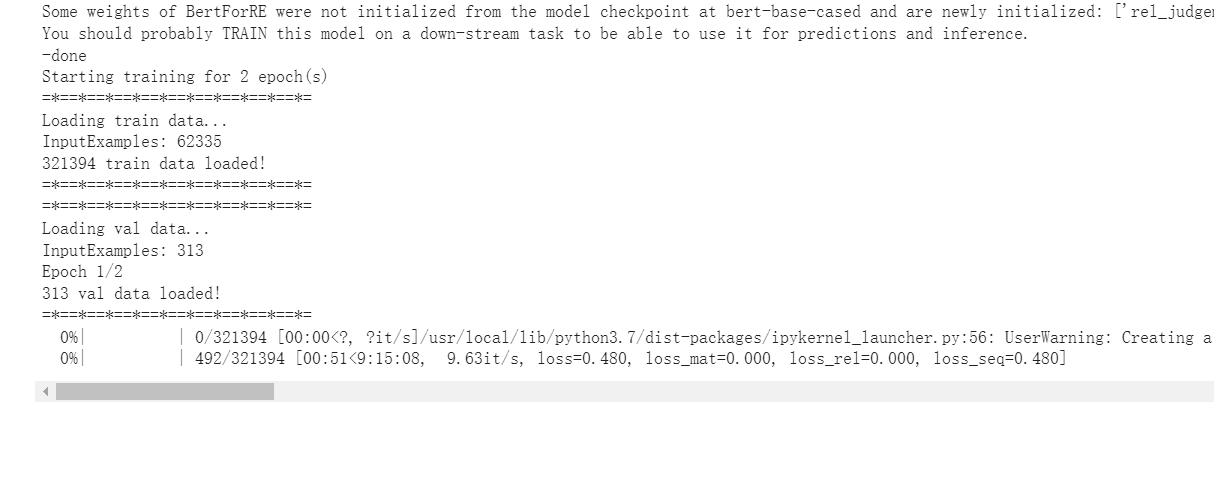

In [ ]:
train_and_evaluate(model, params, ex_params, args.restore_file)


=*==*==*==*==*==*==*==*==*==*=
Loading train data...
InputExamples: 62335


KeyboardInterrupt: ignored

# evaluate

In [ ]:
# /usr/bin/env python
# coding=utf-8
"""Evaluate the model"""
import json
import logging
import random
import argparse

from tqdm import tqdm
import os

import torch
import numpy as np
import pandas as pd

# from metrics import tag_mapping_nearest, tag_mapping_corres
# from utils import Label2IdxSub, Label2IdxObj
# import utils
# from dataloader import CustomDataLoader

# load args
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=2020, help="random seed for initialization")
parser.add_argument('--ex_index', type=str, default=1)
parser.add_argument('--corpus_type', type=str, default="NYT", help="NYT, WebNLG, NYT*, WebNLG*")
parser.add_argument('--device_id', type=int, default=0, help="GPU index")
parser.add_argument('--restore_file', default='last', help="name of the file containing weights to reload")

parser.add_argument('--corres_threshold', type=float, default=0.5, help="threshold of global correspondence")
parser.add_argument('--rel_threshold', type=float, default=0.5, help="threshold of relation judgement")
parser.add_argument('--ensure_corres', action='store_true', help="correspondence ablation")
parser.add_argument('--ensure_rel', action='store_true', help="relation judgement ablation")
parser.add_argument('--emb_fusion', type=str, default="concat", help="way to embedding")

_StoreAction(option_strings=['--emb_fusion'], dest='emb_fusion', nargs=None, const=None, default='concat', type=<class 'str'>, choices=None, help='way to embedding', metavar=None)

In [ ]:



def get_metrics(correct_num, predict_num, gold_num):
    p = correct_num / predict_num if predict_num > 0 else 0
    r = correct_num / gold_num if gold_num > 0 else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    return {
        'correct_num': correct_num,
        'predict_num': predict_num,
        'gold_num': gold_num,
        'precision': p,
        'recall': r,
        'f1': f1
    }


def span2str(triples, tokens):
    def _concat(token_list):
        result = ''
        for idx, t in enumerate(token_list):
            if idx == 0:
                result = t
            elif t.startswith('##'):
                result += t.lstrip('##')
            else:
                result += ' ' + t
        return result

    output = []
    for triple in triples:
        rel = triple[-1]
        sub_tokens = tokens[triple[0][1]:triple[0][-1]]
        obj_tokens = tokens[triple[1][1]:triple[1][-1]]
        sub = _concat(sub_tokens)
        obj = _concat(obj_tokens)
        output.append((sub, obj, rel))
    return output


def evaluate(model, data_iterator, params, ex_params, mark='Val'):
    """Evaluate the model on `steps` batches."""
    # set model to evaluation mode
    model.eval()
    rel_num = params.rel_num

    predictions = []
    ground_truths = []
    correct_num, predict_num, gold_num = 0, 0, 0

    for batch in tqdm(data_iterator, unit='Batch', ascii=True):
        # to device
        batch = tuple(t.to(params.device) if isinstance(t, torch.Tensor) else t for t in batch)
        input_ids, attention_mask, triples, input_tokens = batch
        bs, seq_len = input_ids.size()

        # inference
        with torch.no_grad():
            pred_seqs, pre_corres, xi, pred_rels = model(input_ids, attention_mask=attention_mask,
                                                         ex_params=ex_params)

            # (sum(x_i), seq_len)
            pred_seqs = pred_seqs.detach().cpu().numpy()
            # (bs, seq_len, seq_len)
            pre_corres = pre_corres.detach().cpu().numpy()
        if ex_params['ensure_rel']:
            # (bs,)
            xi = np.array(xi)
            # (sum(s_i),)
            pred_rels = pred_rels.detach().cpu().numpy()
            # decode by per batch
            xi_index = np.cumsum(xi).tolist()
            # (bs+1,)
            xi_index.insert(0, 0)

        for idx in range(bs):
            if ex_params['ensure_rel']:
                pre_triples = tag_mapping_corres(predict_tags=pred_seqs[xi_index[idx]:xi_index[idx + 1]],
                                                 pre_corres=pre_corres[idx],
                                                 pre_rels=pred_rels[xi_index[idx]:xi_index[idx + 1]],
                                                 label2idx_sub=Label2IdxSub,
                                                 label2idx_obj=Label2IdxObj)
            else:
                pre_triples = tag_mapping_corres(predict_tags=pred_seqs[idx * rel_num:(idx + 1) * rel_num],
                                                 pre_corres=pre_corres[idx],
                                                 label2idx_sub=Label2IdxSub,
                                                 label2idx_obj=Label2IdxObj)

            gold_triples = span2str(triples[idx], input_tokens[idx])
            pre_triples = span2str(pre_triples, input_tokens[idx])
            ground_truths.append(list(set(gold_triples)))
            predictions.append(list(set(pre_triples)))
            # counter
            correct_num += len(set(pre_triples) & set(gold_triples))
            predict_num += len(set(pre_triples))
            gold_num += len(set(gold_triples))
    metrics = get_metrics(correct_num, predict_num, gold_num)
    # logging loss, f1 and report
    metrics_str = "; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics.items())
    logging.info("- {} metrics:\n".format(mark) + metrics_str)
    return metrics, predictions, ground_truths




In [ ]:
if __name__ == '__main__':
    # args = parser.parse_args()
    args =parser.parse_args(args=[])
    params = Params(ex_index=args.ex_index, corpus_type=args.corpus_type)
    ex_params = {
        'corres_threshold': args.mat_threshold,
        'rel_threshold': args.rel_pre_threshold,
        'ensure_corres': args.ensure_match,
        'ensure_rel': args.ensure_relpre,
        'emb_fusion': args.emb_fusion
    }

    torch.cuda.set_device(args.device_id)
    print('current device:', torch.cuda.current_device())
    mode = args.mode
    # Set the random seed for reproducible experiments
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    params.seed = args.seed

    # Set the logger
    set_logger()

    # get dataloader
    dataloader = CustomDataLoader(params)

    # Define the model
    logging.info('Loading the model...')
    logging.info(f'Path: {os.path.join(params.model_dir, args.restore_file)}.pth.tar')
    # Reload weights from the saved file
    model, optimizer = load_checkpoint(os.path.join(params.model_dir, args.restore_file + '.pth.tar'))
    model.to(params.device)
    logging.info('- done.')

    logging.info("Loading the dataset...")
    loader = dataloader.get_dataloader(data_sign=mode, ex_params=ex_params)
    logging.info('-done')

    logging.info("Starting prediction...")
    _, predictions, ground_truths = evaluate(model, loader, params, ex_params, mark=mode)
    with open(params.data_dir / f'{mode}_triples.json', 'r', encoding='utf-8') as f_src:
        src = json.load(f_src)
        df = pd.DataFrame(
            {
                'text': [sample['text'] for sample in src],
                'pre': predictions,
                'truth': ground_truths
            }
        )
        df.to_csv(params.ex_dir / f'{mode}_result.csv')
    logging.info('-done')


usage: ipykernel_launcher.py [-h] [--seed SEED] [--ex_index EX_INDEX]
                             [--corpus_type CORPUS_TYPE]
                             [--device_id DEVICE_ID] --epoch_num EPOCH_NUM
                             [--restore_file RESTORE_FILE]
                             [--corres_threshold CORRES_THRESHOLD]
                             [--rel_threshold REL_THRESHOLD] [--ensure_corres]
                             [--ensure_rel] [--emb_fusion EMB_FUSION]
                             [--num_negs NUM_NEGS]
ipykernel_launcher.py: error: the following arguments are required: --epoch_num


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
